In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns

In [2]:
def get_mb(validation, x):
    
    mean_bias = 1/len(validation) * sum(abs(x - validation))
    
    return mean_bias

def get_rmse(validation, x):
    
    rmse = np.sqrt(((x - validation)**2).mean())
    
    return rmse

def get_ce(validation, x):
    
    v_bar = np.mean(validation)
    
    numerator = sum((validation - x)**2)

    denominator = sum((validation - v_bar)**2)
    
    ce = 1 - numerator/denominator
    
    return ce

def get_diagnostic_matrix(list_of_data, variables, diagnostic, obs):
    """
    list_of_data: a list of data arrays for cases being evaluated
    variables: a list of variable names
    diagnostic: a string name for the diagnostic
    obs: a list of observations associated with each variable in "variables"
    """

    DIAG = []
    
    obs_count = 0 
    for variable in variables:
        diag_var = [] 
        
        if variable not in ['aice','hi','vsno']:
            print('variable not recognized! please choose between "aice", "hi", and "vsno"')
        else:    
            for array in list_of_data:
                if diagnostic == 'rmse':
                    metric = get_rmse(array[variable], obs[obs_count])
                elif diagnostic == 'mb':
                    metric = get_mb(array[variable], obs[obs_count])
                elif diagnostic == 'ce':
                    metric = get_ce(array[variable], obs[obs_count])
                else:
                    print('diagnostic not recognized! please choose between "rmse", "mb", and "ce"')
                diag_var.append(metric)
        
            DIAG.append(diag_var)
            obs_count += 1
    
    DIAG = np.array(DIAG)
    return DIAG

def add_snow(data):
    
    for i in range(0, len(data)):
        if 'vsnon' in list(data[i].keys()):
            data[i]['vsno'] = data[i].vsnon.sum(dim='ncat')
        else: 
            data[i]['vsno'] = data[i].vsno01 + data[i].vsno02 + data[i].vsno03 + data[i].vsno04 + data[i].vsno05
        
    return data

Formulate the list of data, variables, and observations 

In [3]:
case_list = ['SIT_f1_NORM_test', 'SIC_f1_NORM_test', 'AGR_f1_NORM_opt1',
             'VIC_f1_NORM_test', 'AIC_f1_NORM_test', 'CAT_f1_NORM_opt1',
             'SIT_f1_BNRH_test', 'SIC_f1_BNRH_test', 'AGR_f1_BNRH_opt1',
             'VIC_f1_BNRH_test', 'AIC_f1_BNRH_test', 'CAT_f1_BNRH_opt1',
             'SIT_f101_NORM_test', 'SIC_f101_NORM_test', 'AGR_f101_NORM_opt1',
             'VIC_f101_NORM_test', 'AIC_f101_NORM_test', 'CAT_f101_NORM_opt1',
             'SIT_f101_BNRH_test', 'SIC_f101_BNRH_test', 'AGR_f101_BNRH_opt1',
             'VIC_f101_BNRH_test', 'AIC_f101_BNRH_test', 'CAT_f101_BNRH_opt1',]

CASES = []
for case in case_list:
    ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/'+case+'/postprocessed_mean.nc')
    ds = ds.isel({'ni':2})
    ds['vice'] = ds.vicen.sum(dim='ncat')
    ds['aice'] = ds.aicen.sum(dim='ncat')
    ds['hi'] = ds.vice/ds.aice
    
    if 'vsnon' in list(ds.keys()):
        ds['vsno'] = ds.vsnon.sum(dim='ncat')
    else: 
        ds['vsno'] = ds.vsno01 + ds.vsno02 + ds.vsno03 + ds.vsno04 + ds.vsno05
    
    CASES.append(ds)
    
free_ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/FREE/free_ens.nc')

In [4]:
CASES.append(free_ds[['aice','hi','vice','vsno', 'vsnon','vicen','aicen']].mean(dim='ensemble_member').transpose('time','ncat'))

In [5]:
variables = ['aice','hi','vsno']

file = "/glade/work/mollyw/Projects/cice-scm-da/data/processed/synthetic_obs/free_test/netcdfs/aggregate_observations.nc"
obs_test = xr.open_dataset(file)
truth = obs_test.sel({"copy": 2})

sic_obs = truth.observations[1:1092:3].values
sit_obs = truth.observations[0:1092:3].values
sno_obs = free_ds.isel({'ensemble_member':13}).vsnon.sum(dim='ncat').values

OBS = [sic_obs, sit_obs, sno_obs]

In [6]:
MB = get_diagnostic_matrix(CASES, variables, 'mb', OBS)
RMSE = get_diagnostic_matrix(CASES, variables, 'rmse', OBS)
CE = get_diagnostic_matrix(CASES, variables, 'ce', OBS)

In [7]:
pMB = (MB[:, -1] - MB[:, :-1].transpose())/MB[:, -1]
pRMSE = (RMSE[:, -1] - RMSE[:, :-1].transpose())/RMSE[:, -1]
iCE = CE[:, :-1].transpose() - CE[:,-1]

In [8]:
pMB = np.reshape(pMB, (4,6,3))
pRMSE= np.reshape(pRMSE, (4,6,3))
iCE = np.reshape(iCE, (4,6,3))

# pMB = np.transpose(pMB, (1,0,2))
# pRMSE= np.transpose(pRMSE, (1,0,2))
# iCE = np.transpose(iCE, (1,0,2))

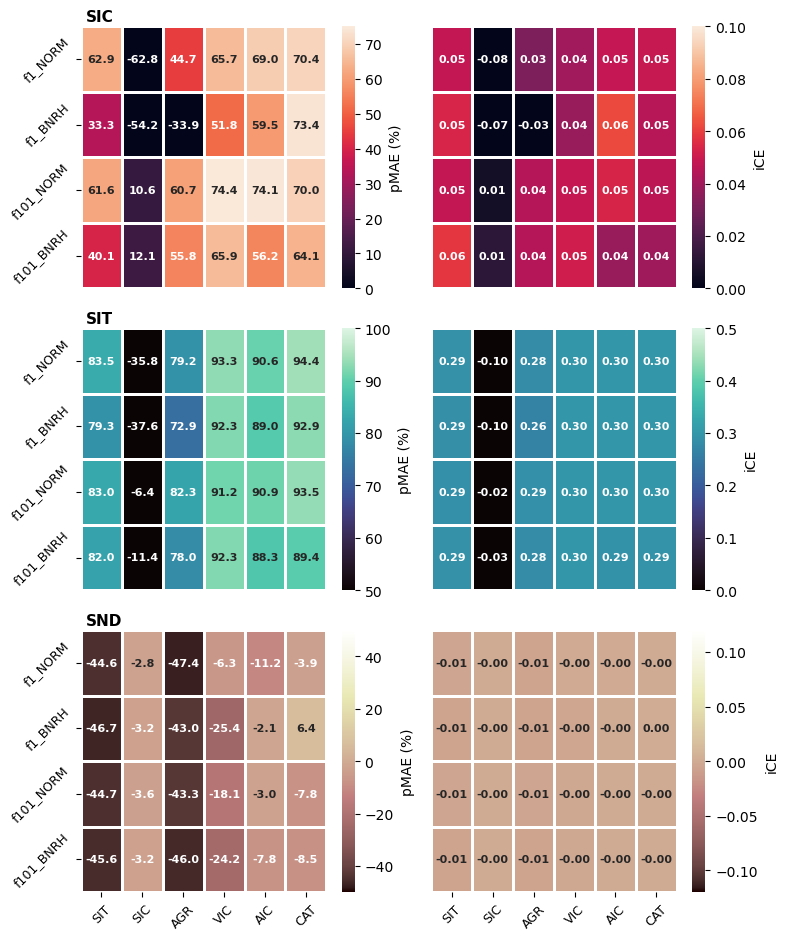

In [21]:
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (8,9.5))

# plot mean bias for SIC 
df = pd.DataFrame(pMB[:,:,0], columns = ['SIT','SIC','AGR','VIC','AIC', 'CAT'], index = ['f1_NORM','f1_BNRH','f101_NORM','f101_BNRH'])
f1 = sns.heatmap(df*100, vmin = 0, vmax = 75, cmap = 'rocket', 
                 annot=True, annot_kws={"size": 8, "weight": "bold"},
                 fmt=".1f", linewidth = 1, ax = axes[0][0], xticklabels = False)
f1.collections[0].colorbar.set_label('pMAE (%)', labelpad=5, fontsize=10)
axes[0][0].text(0.02, 1.02,'SIC',
             transform=axes[0][0].transAxes,
             fontsize=11, fontweight='bold')
f1.tick_params(labelsize=9, rotation = 45)


# plot mean bias for SIT
df = pd.DataFrame(pMB[:,:,1], columns = ['SIT','SIC','AGR','VIC','AIC', 'CAT'], index = ['f1_NORM','f1_BNRH','f101_NORM','f101_BNRH'])
f2 = sns.heatmap(df*100, vmin = 50, vmax = 100, cmap = 'mako', 
                 annot=True, annot_kws={"size": 8, "weight": "bold"},
                 fmt=".1f", linewidth = 1, ax = axes[1][0], xticklabels = False)
f2.collections[0].colorbar.set_label('pMAE (%)', labelpad=5, fontsize=10)
axes[1][0].text(0.02, 1.02,'SIT',
             transform=axes[1][0].transAxes,
             fontsize=11, fontweight='bold')
f2.tick_params(labelsize=9, rotation = 45)

# plot mean bias for SND
df = pd.DataFrame(pMB[:,:,2], columns = ['SIT','SIC','AGR','VIC','AIC', 'CAT'], index = ['f1_NORM','f1_BNRH','f101_NORM','f101_BNRH'])
f3 = sns.heatmap(df*100, 
            vmin = -50, vmax = 50, cmap = 'pink', 
            annot=True, annot_kws={"size": 8, "weight": "bold"},
            fmt=".1f", linewidth = 1, ax = axes[2][0])
f3.collections[0].colorbar.set_label('pMAE (%)', labelpad=5, fontsize=10)
axes[2][0].text(0.02, 1.02,'SND',
             transform=axes[2][0].transAxes,
             fontsize=11, fontweight='bold')
f3.tick_params(labelsize=9, rotation = 45)

# plot CE for SIC
df = pd.DataFrame(iCE[:,:,0], columns = ['SIT','SIC','AGR','VIC','AIC', 'CAT'], index = ['f1_NORM','f1_BNRH','f101_NORM','f101_BNRH'])
f4 = sns.heatmap(df, vmin = 0, vmax = 0.1, cmap = 'rocket', 
                 annot=True, annot_kws={"size": 8, "weight": "bold"},
                 fmt=".2f", linewidth = 1, ax = axes[0][1], yticklabels=False, xticklabels = False)
f4.collections[0].colorbar.set_label('iCE', labelpad=5, fontsize=10)

# plot CE for SIT
df = pd.DataFrame(iCE[:,:,1], columns = ['SIT','SIC','AGR','VIC','AIC', 'CAT'], index = ['f1_NORM','f1_BNRH','f101_NORM','f101_BNRH'])
f5 = sns.heatmap(df, vmin = 0 , vmax = 0.5, cmap = 'mako', 
                 annot=True, annot_kws={"size": 8, "weight": "bold"},
                 fmt=".2f", linewidth = 1, ax = axes[1][1], xticklabels = False, yticklabels = False)
f5.collections[0].colorbar.set_label('iCE', labelpad=5, fontsize=10)

# plot CE for SND
df = pd.DataFrame(iCE[:,:,2], columns = ['SIT','SIC','AGR','VIC','AIC','CAT'], index = ['f1_NORM','f1_BNRH','f101_NORM','f101_BNRH'])
f6 = sns.heatmap(df, vmin = -0.12 , vmax = 0.12, cmap = 'pink', 
                 annot=True, annot_kws={"size": 8, "weight": "bold"},
                 fmt=".2f", linewidth = 1, ax = axes[2][1], yticklabels = False)
f6.collections[0].colorbar.set_label('iCE', labelpad=5, fontsize=10)
# f6.set_xticklabels(fontsize=10)
f6.tick_params(labelsize=9, rotation=45)


# # plt.suptitle('Error Reduction as a Result of Assimilation', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('figures/mae_ce_heatmaps.png', dpi=300, bbox_inches='tight')

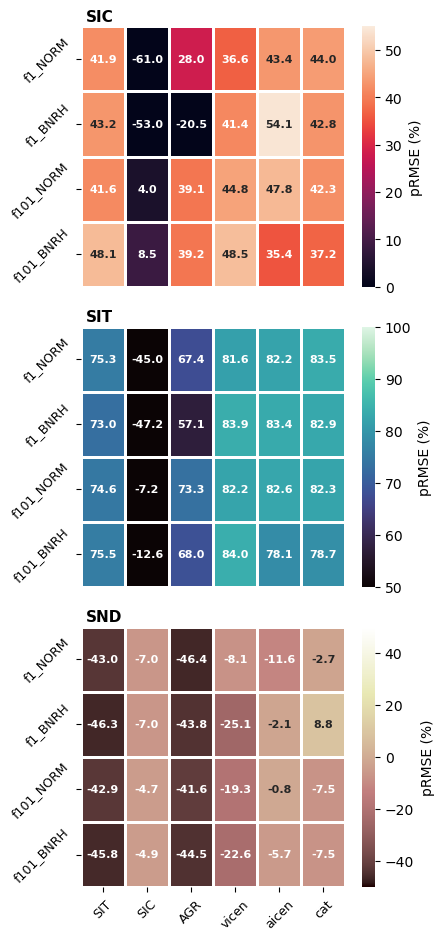

In [23]:
fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (4.5,9.5))

# plot mean bias for SIC 
df = pd.DataFrame(pRMSE[:,:,0], columns = ['SIT','SIC','AGR','vicen','aicen', 'cat'], index = ['f1_NORM','f1_BNRH','f101_NORM','f101_BNRH'])
f1 = sns.heatmap(df*100, vmin = 0, vmax = 55, cmap = 'rocket', 
                 annot=True, annot_kws={"size": 8, "weight": "bold"},
                 fmt=".1f", linewidth = 1, ax = axes[0], xticklabels = False)
f1.collections[0].colorbar.set_label('pRMSE (%)', labelpad=5, fontsize=10)
axes[0].text(0.02, 1.02,'SIC',
             transform=axes[0].transAxes,
             fontsize=11, fontweight='bold')
f1.tick_params(labelsize=9, rotation = 45)


# plot mean bias for SIT
df = pd.DataFrame(pRMSE[:,:,1], columns = ['SIT','SIC','AGR','vicen','aicen', 'cat'], index = ['f1_NORM','f1_BNRH','f101_NORM','f101_BNRH'])
f2 = sns.heatmap(df*100, vmin = 50, vmax = 100, cmap = 'mako', 
                 annot=True, annot_kws={"size": 8, "weight": "bold"},
                 fmt=".1f", linewidth = 1, ax = axes[1], xticklabels = False)
f2.collections[0].colorbar.set_label('pRMSE (%)', labelpad=5, fontsize=10)
axes[1].text(0.02, 1.02,'SIT',
             transform=axes[1].transAxes,
             fontsize=11, fontweight='bold')
f2.tick_params(labelsize=9, rotation = 45)

# plot mean bias for SND
df = pd.DataFrame(pRMSE[:,:,2], columns = ['SIT','SIC','AGR','vicen','aicen', 'cat'], index = ['f1_NORM','f1_BNRH','f101_NORM','f101_BNRH'])
f3 = sns.heatmap(df*100, 
            vmin = -50, vmax = 50, cmap = 'pink', 
            annot=True, annot_kws={"size": 8, "weight": "bold"},
            fmt=".1f", linewidth = 1, ax = axes[2])
f3.collections[0].colorbar.set_label('pRMSE (%)', labelpad=5, fontsize=10)
axes[2].text(0.02, 1.02,'SND',
             transform=axes[2].transAxes,
             fontsize=11, fontweight='bold')
f3.tick_params(labelsize=9, rotation = 45)


# # plt.suptitle('Error Reduction as a Result of Assimilation', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('figures/rmse_heatmap.png', dpi=300, bbox_inches='tight')